In [1]:
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random


### Before starting there are some important terms

- ETT Abnormal (endotracheal tube placement abnormal)
- ETT Borderline (endotracheal tube placement borderline abnormal)
- ETT Normal (endotracheal tube placement normal)
- NGT Abnormal (nasogastric tube placement abnormal)
- NGT Borderline (nasogastric tube placement borderline abnormal)
- NGT Incompletely Imaged (nasogastric tube placement inconclusive due to imaging)
- NGT Normal (nasogastric tube placement borderline normal)
- CVC Abnormal (central venous catheter placement abnormal)
- CVC Borderline (central venous catheter placement borderline abnormal)
- CVC Normal (central venous catheter placement normal)
- Swan Ganz Catheter Present

In [2]:
BASE_DIR = "../input/ranzcr-clip-catheter-line-classification"

In [3]:
train = pd.read_csv(f"{BASE_DIR}/train.csv", index_col=0)
train_annotations = pd.read_csv(f"{BASE_DIR}/train_annotations.csv")

In [4]:
train.shape

(30083, 12)

In [5]:
train.head()

ETT - Abnormal  \
StudyInstanceUID                                                     
1.2.826.0.1.3680043.8.498.266976289532732281893...               0   
1.2.826.0.1.3680043.8.498.463028915973987587598...               0   
1.2.826.0.1.3680043.8.498.238192607197484948589...               0   
1.2.826.0.1.3680043.8.498.682866432023232128012...               0   
1.2.826.0.1.3680043.8.498.100502030092259382591...               0   

                                                    ETT - Borderline  \
StudyInstanceUID                                                       
1.2.826.0.1.3680043.8.498.266976289532732281893...                 0   
1.2.826.0.1.3680043.8.498.463028915973987587598...                 0   
1.2.826.0.1.3680043.8.498.238192607197484948589...                 0   
1.2.826.0.1.3680043.8.498.682866432023232128012...                 0   
1.2.826.0.1.3680043.8.498.100502030092259382591...                 0   

                                                    ETT - Normal  \
StudyInstanceUID                                                   
1.2.826.0.1.3680043.8.498.266976289532732281893...             0   
1.2.826.0.1.3680043.8.498.463028915973987587598...             1   
1.2.826.0.1.3680043.8.498.238192607197484948589...             0   
1.2.826.0.1.3680043.8.498.682866432023232128012...             0   
1.2.826.0.1.3680043.8.498.100502030092259382591...             0   

                                                    NGT - Abnormal  \
StudyInstanceUID                                                     
1.2.826.0.1.3680043.8.498.266976289532732281893...               0   
1.2.826.0.1.3680043.8.498.463028915973987587598...               0   
1.2.826.0.1.3680043.8.498.238192607197484948589...               0   
1.2.826.0.1.3680043.8.498.682866432023232128012...               0   
1.2.826.0.1.3680043.8.498.100502030092259382591...               0   

                                                    NGT - Borderline  \
StudyInstanceUID                                                       
1.2.826.0.1.3680043.8.498.266976289532732281893...                 0   
1.2.826.0.1.3680043.8.498.463028915973987587598...                 0   
1.2.826.0.1.3680043.8.498.238192607197484948589...                 0   
1.2.826.0.1.3680043.8.498.682866432023232128012...                 0   
1.2.826.0.1.3680043.8.498.100502030092259382591...                 0   

                                                    NGT - Incompletely Imaged  \
StudyInstanceUID                                                                
1.2.826.0.1.3680043.8.498.266976289532732281893...                          0   
1.2.826.0.1.3680043.8.498.463028915973987587598...                          1   
1.2.826.0.1.3680043.8.498.238192607197484948589...                          0   
1.2.826.0.1.3680043.8.498.682866432023232128012...                          0   
1.2.826.0.1.3680043.8.498.100502030092259382591...                          0   

                                                    NGT - Normal  \
StudyInstanceUID                                                   
1.2.826.0.1.3680043.8.498.266976289532732281893...             1   
1.2.826.0.1.3680043.8.498.463028915973987587598...             0   
1.2.826.0.1.3680043.8.498.238192607197484948589...             0   
1.2.826.0.1.3680043.8.498.682866432023232128012...             0   
1.2.826.0.1.3680043.8.498.100502030092259382591...             0   

                                                    CVC - Abnormal  \
StudyInstanceUID                                                     
1.2.826.0.1.3680043.8.498.266976289532732281893...               0   
1.2.826.0.1.3680043.8.498.463028915973987587598...               0   
1.2.826.0.1.3680043.8.498.238192607197484948589...               0   
1.2.826.0.1.3680043.8.498.682866432023232128012...               1   
1.2.826.0.1.3680043.8.498.100502030092259382591...               0   

                                               

In [6]:
train.iloc[:, :-1].sum()

ETT - Abnormal                   79
ETT - Borderline               1138
ETT - Normal                   7240
NGT - Abnormal                  279
NGT - Borderline                529
NGT - Incompletely Imaged      2748
NGT - Normal                   4797
CVC - Abnormal                 3195
CVC - Borderline               8460
CVC - Normal                  21324
Swan Ganz Catheter Present      830
dtype: int64

In [7]:
def display_image(img_ids):
    plt.figure(figsize=(14, 10))
    
    for index, img_id in enumerate(img_ids):
        plt.subplot(3, 4, index + 1)
        img = cv2.imread(os.path.join(BASE_DIR, "train", f"{img_id}.jpg"))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(img)
        plt.axis("off")
    
    plt.show()
    

def disp_describe(df, col):
    print("Distribution:")
    print(df[col].value_counts())
    print()
    print(f"Percent of 1: {df[col].mean():.4f}")
    

def disp_image_with_annotate(df, row_ind):
    row = df.iloc[row_ind]
    img_path = os.path.join(BASE_DIR, "train", row["StudyInstanceUID"] + ".jpg")
    label = row["label"]
    data = np.array(ast.literal_eval(row["data"]))
    
    plt.figure(figsize=(10, 5))
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.scatter(data[:, 0], data[:, 1])
    
    plt.suptitle(label, fontsize=14)

In [8]:
train_annotations.shape

(17999, 3)

In [9]:
train_annotations.head()

StudyInstanceUID             label  \
0  1.2.826.0.1.3680043.8.498.12616281126973421762...      CVC - Normal   
1  1.2.826.0.1.3680043.8.498.12616281126973421762...      CVC - Normal   
2  1.2.826.0.1.3680043.8.498.72921907356394389969...  CVC - Borderline   
3  1.2.826.0.1.3680043.8.498.11697104485452001927...      CVC - Normal   
4  1.2.826.0.1.3680043.8.498.87704688663091069148...      NGT - Normal   

                                                data  
0  [[1487, 1279], [1477, 1168], [1472, 1052], [14...  
1  [[1328, 7], [1347, 101], [1383, 193], [1400, 2...  
2  [[801, 1207], [812, 1112], [823, 1023], [842, ...  
3  [[1366, 961], [1411, 861], [1453, 751], [1508,...  
4  [[1862, 14], [1845, 293], [1801, 869], [1716, ...

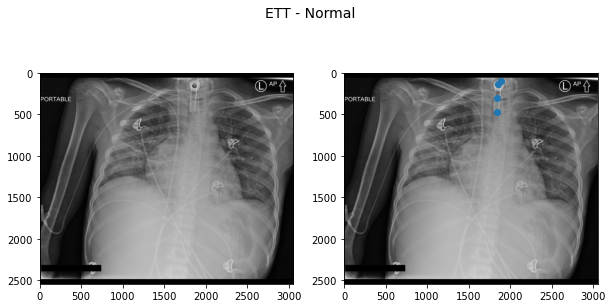

In [10]:
disp_image_with_annotate(train_annotations, 10)

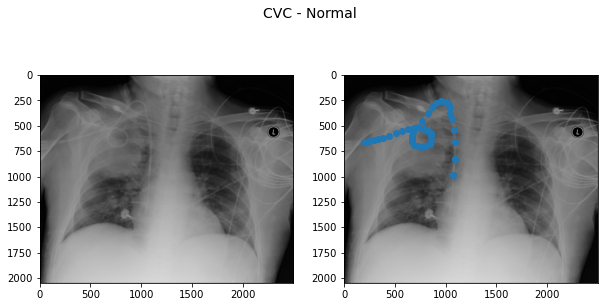

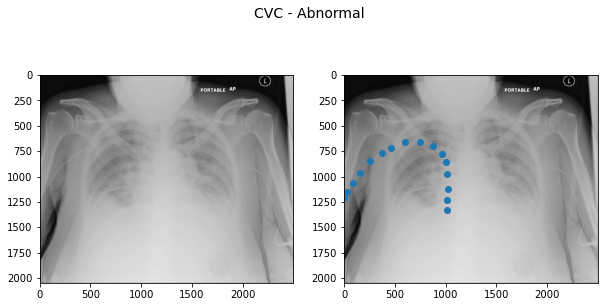

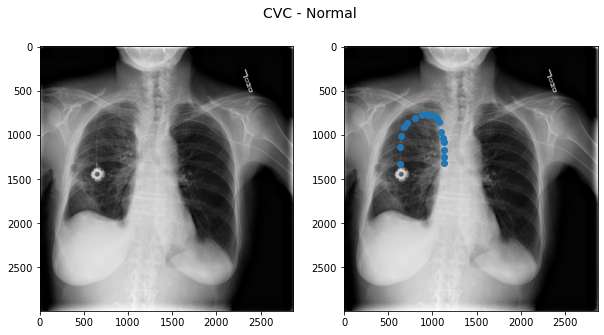

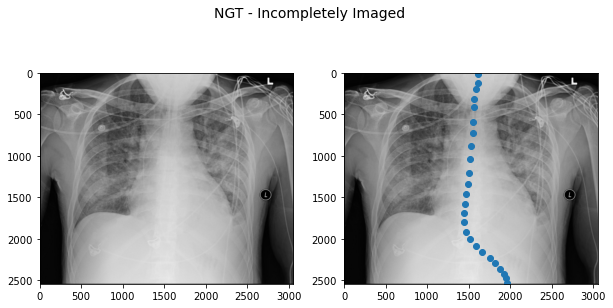

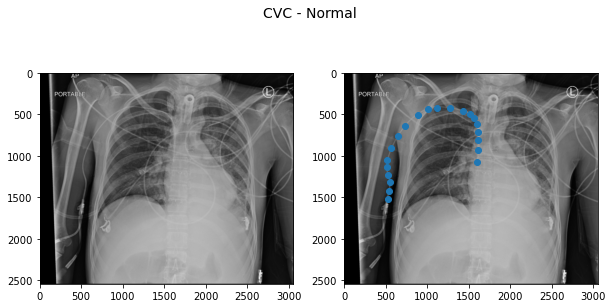

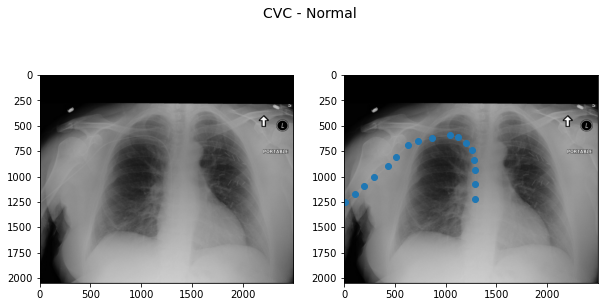

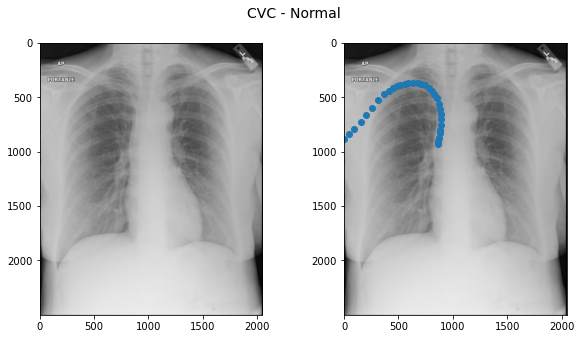

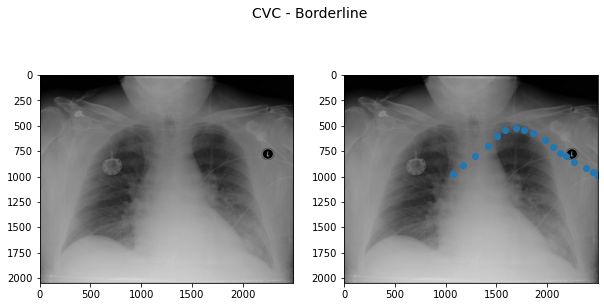

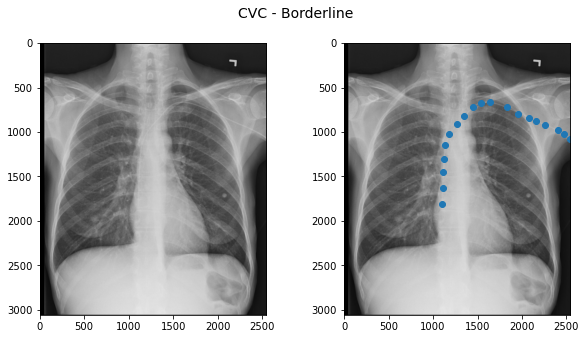

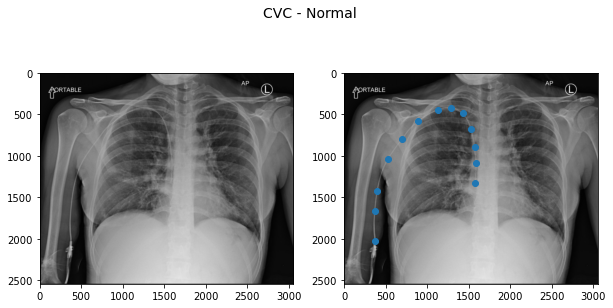

In [11]:
for i in range(10):
    disp_image_with_annotate(train_annotations, random.randint(0, 1500))

In [12]:
train.columns

Index(['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal',
       'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal',
       'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
       'Swan Ganz Catheter Present', 'PatientID'],
      dtype='object')

### ETT Abnormal

Distribution:
0    30004
1       79
Name: ETT - Abnormal, dtype: int64

Percent of 1: 0.0026


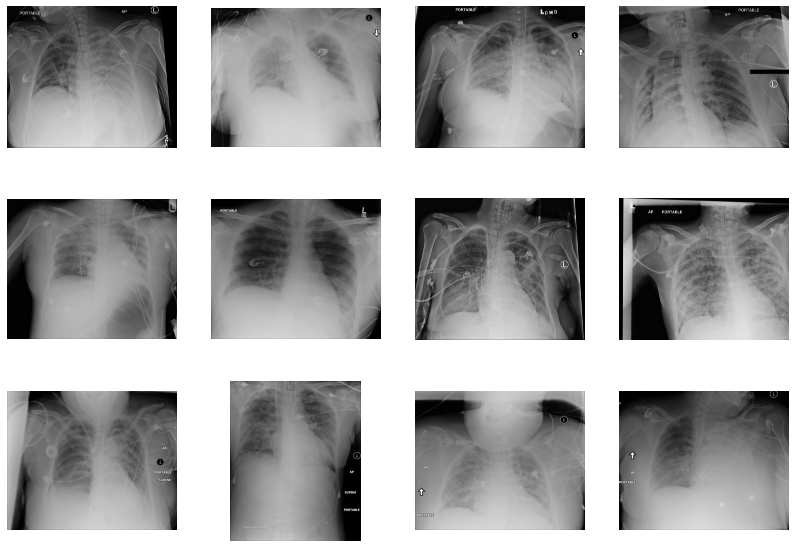

In [13]:
col_name = "ETT - Abnormal"
disp_describe(train, col_name)
tmp_df = train[train[col_name] == 1]
display_image(random.sample(tmp_df.index.tolist(), 12))

### ETT Borderline

Distribution:
0    28945
1     1138
Name: ETT - Borderline, dtype: int64

Percent of 1: 0.0378


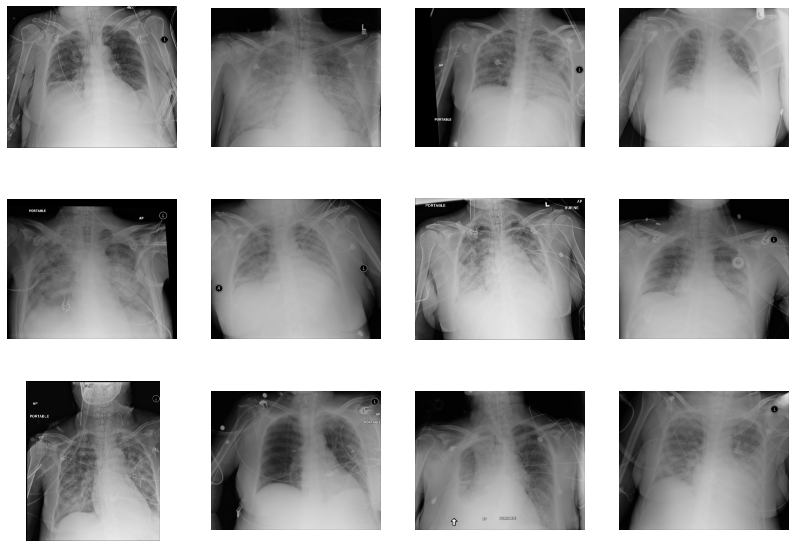

In [14]:
col_name = "ETT - Borderline"
disp_describe(train, col_name)
tmp_df = train[train[col_name] == 1]
display_image(random.sample(tmp_df.index.tolist(), 12))

### ETT Normal

Distribution:
0    22843
1     7240
Name: ETT - Normal, dtype: int64

Percent of 1: 0.2407


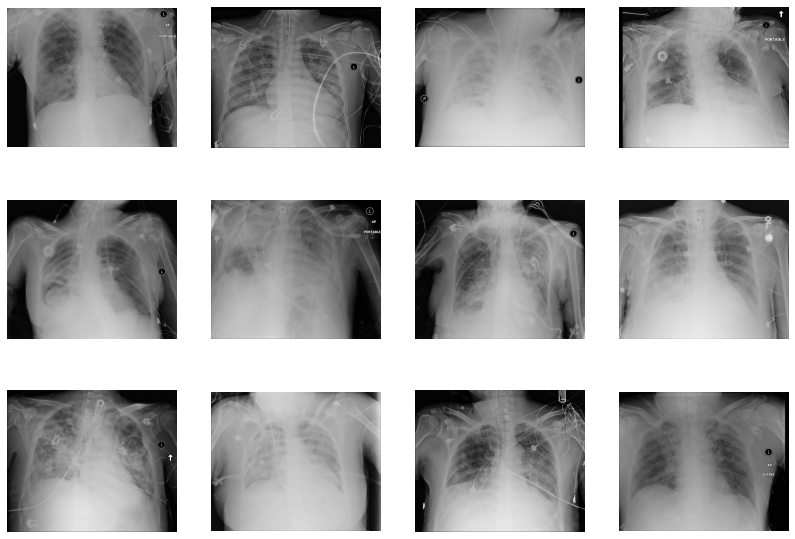

In [15]:
col_name = "ETT - Normal"
disp_describe(train, col_name)
tmp_df = train[train[col_name] == 1]
display_image(random.sample(tmp_df.index.tolist(), 12))

### NGT Abnormal

Distribution:
0    29804
1      279
Name: NGT - Abnormal, dtype: int64

Percent of 1: 0.0093


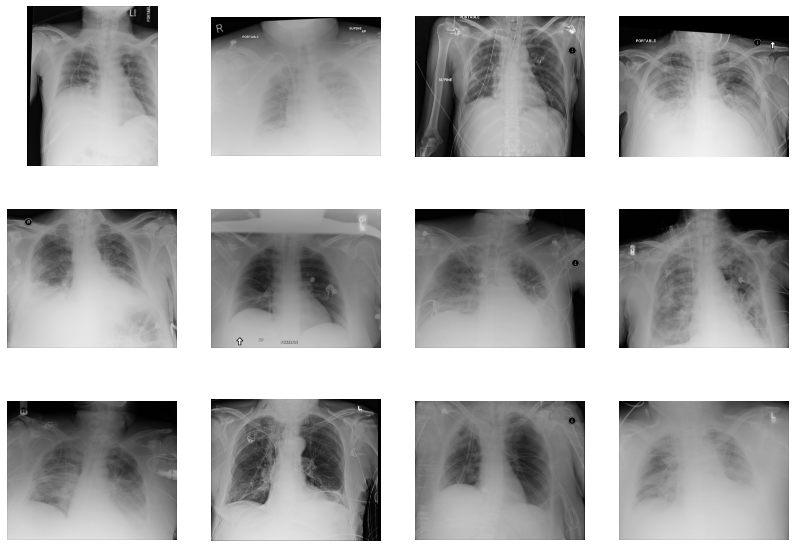

In [16]:
col_name = "NGT - Abnormal"
disp_describe(train, col_name)
tmp_df = train[train[col_name] == 1]
display_image(random.sample(tmp_df.index.tolist(), 12))

### NGT Borderline

Distribution:
0    29554
1      529
Name: NGT - Borderline, dtype: int64

Percent of 1: 0.0176


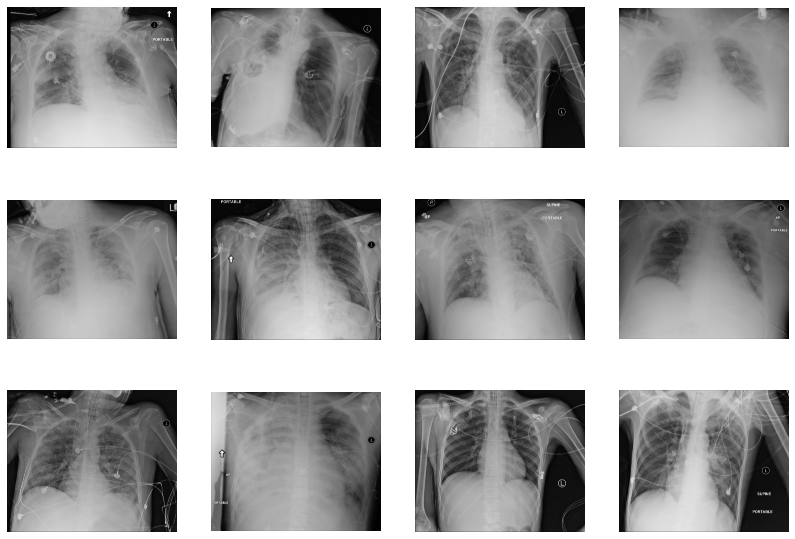

In [17]:
col_name = "NGT - Borderline"
disp_describe(train, col_name)
tmp_df = train[train[col_name] == 1]
display_image(random.sample(tmp_df.index.tolist(), 12))

### NGT Incompletely Imaged

Distribution:
0    27335
1     2748
Name: NGT - Incompletely Imaged, dtype: int64

Percent of 1: 0.0913


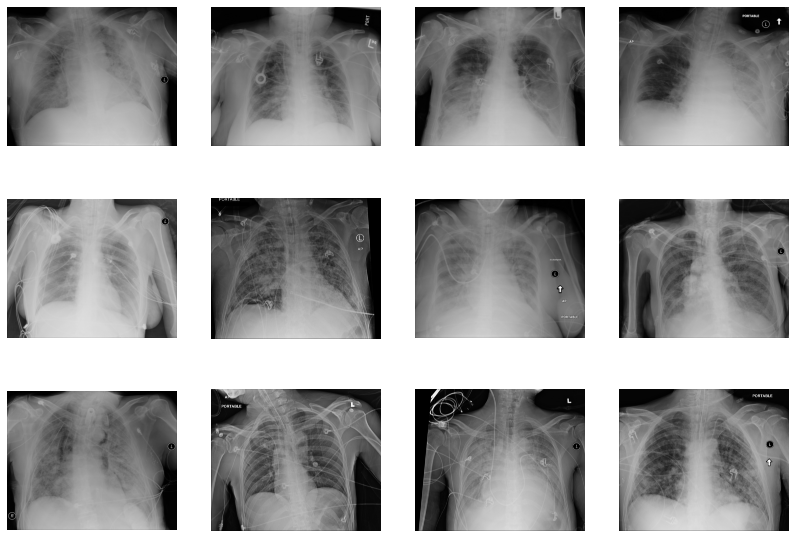

In [18]:
col_name = "NGT - Incompletely Imaged"
disp_describe(train, col_name)
tmp_df = train[train[col_name] == 1]
display_image(random.sample(tmp_df.index.tolist(), 12))

### NGT Normal

Distribution:
0    25286
1     4797
Name: NGT - Normal, dtype: int64

Percent of 1: 0.1595


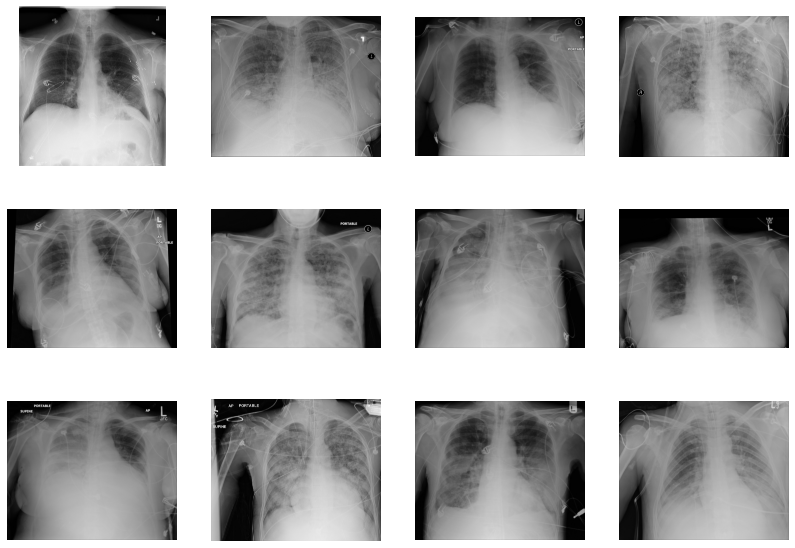

In [19]:
col_name = "NGT - Normal"
disp_describe(train, col_name)
tmp_df = train[train[col_name] == 1]
display_image(random.sample(tmp_df.index.tolist(), 12))

### CVC Abnormal

Distribution:
0    26888
1     3195
Name: CVC - Abnormal, dtype: int64

Percent of 1: 0.1062


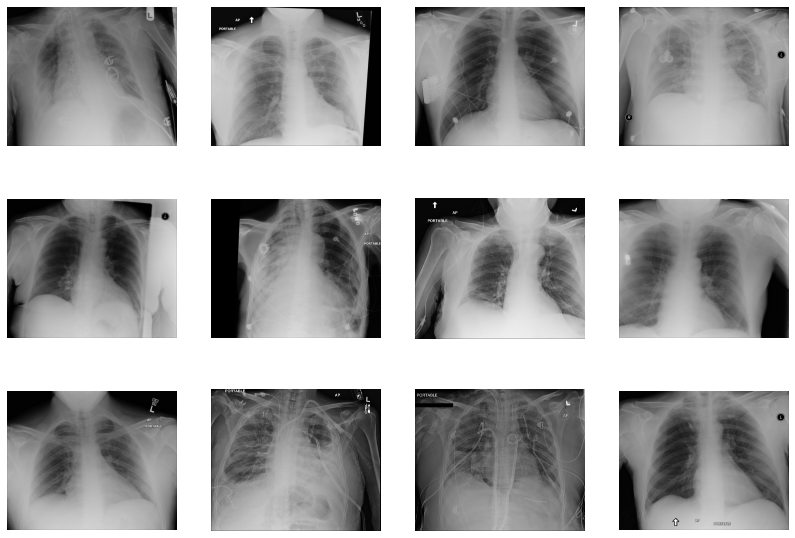

In [20]:
col_name = "CVC - Abnormal"
disp_describe(train, col_name)
tmp_df = train[train[col_name] == 1]
display_image(random.sample(tmp_df.index.tolist(), 12))

### CVC Borderline

Distribution:
0    21623
1     8460
Name: CVC - Borderline, dtype: int64

Percent of 1: 0.2812


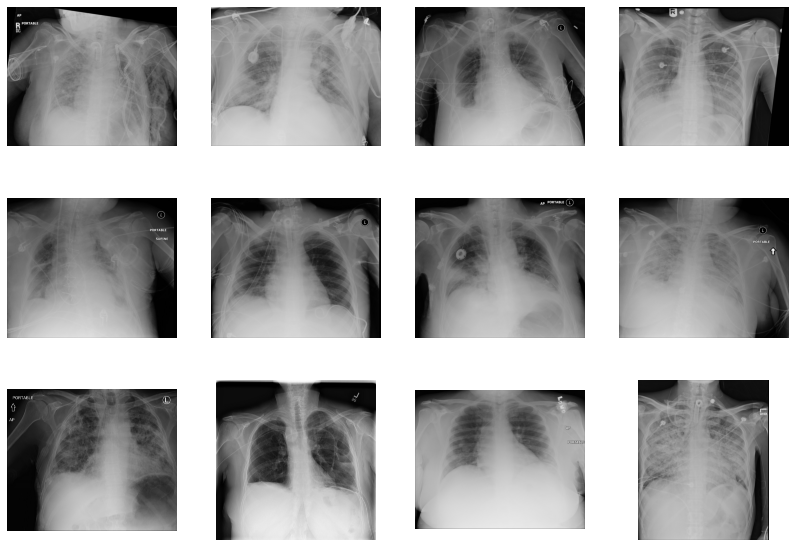

In [21]:
col_name = "CVC - Borderline"
disp_describe(train, col_name)
tmp_df = train[train[col_name] == 1]
display_image(random.sample(tmp_df.index.tolist(), 12))

### CVC Normal

Distribution:
1    21324
0     8759
Name: CVC - Normal, dtype: int64

Percent of 1: 0.7088


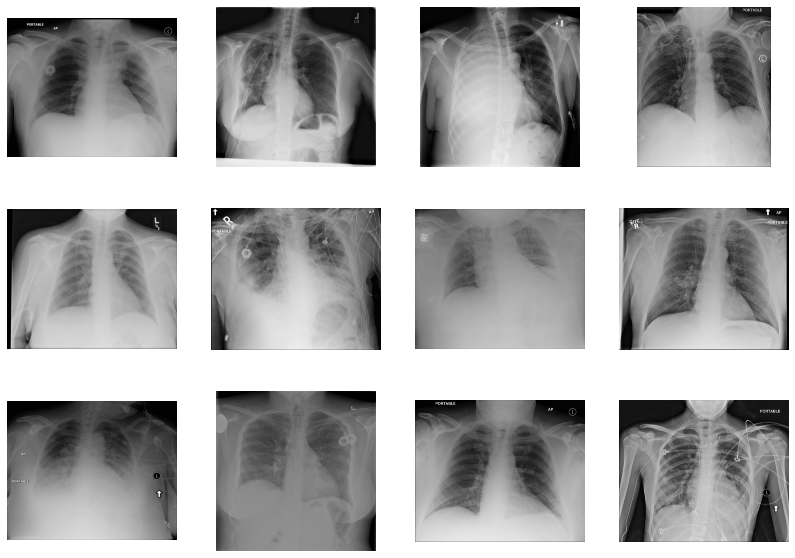

In [22]:
col_name = "CVC - Normal"
disp_describe(train, col_name)
tmp_df = train[train[col_name] == 1]
display_image(random.sample(tmp_df.index.tolist(), 12))

### Swan Ganz Catheter Present

Distribution:
0    29253
1      830
Name: Swan Ganz Catheter Present, dtype: int64

Percent of 1: 0.0276


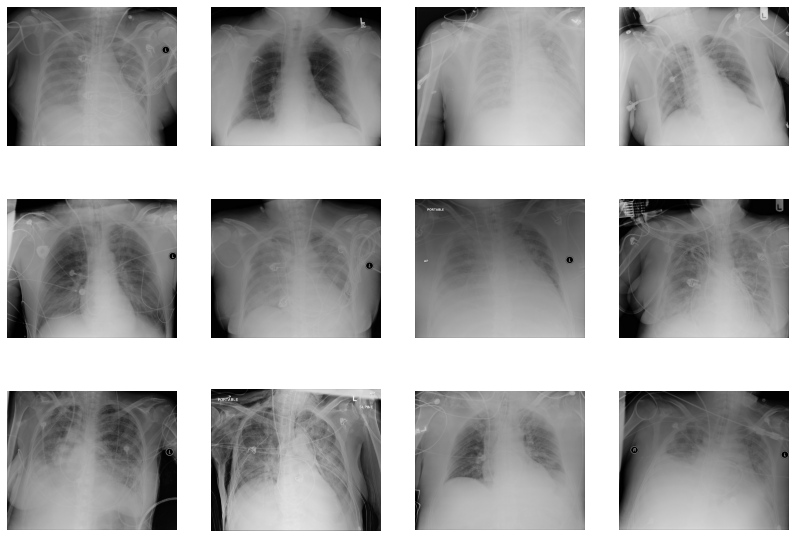

In [23]:
col_name = "Swan Ganz Catheter Present"
disp_describe(train, col_name)
tmp_df = train[train[col_name] == 1]
display_image(random.sample(tmp_df.index.tolist(), 12))